# API EXAMPLES FOR ``pySubnetSB``

**Background**

Many advances in biomedical research are driven by structural analysis, a study of the interconnections
between elements in biological systems (e.g., identifying drug target based on the structure of chemical pathways).
Structural analysis appeals because such information is generally much easier to obtain than dynamical data such as
species concentrations and reaction fluxes. Our focus is on subnet discovery in chemical reaction networks (CRNs);
that is, discovering a subset of a target CRN that is structurally identical to a reference CRN. Applications of subnet
discovery include the discovery of conserved chemical pathways and the elucidation of the structure of complex CRNs.
Although there are theoretical results for finding subgraphs, we are unaware of tools for CRN subnet discovery. This is
in part due to the special characteristics of CRN graphs, that they are directed, bipartite, hypergraphs.

``pySubnetSB``

``pySubnetSB`` is an open source Python package for discovering subnets represented in the systems
biology markup language (SBML) community standard. ``pySubnetSB`` uses a constraint-based approach to discover
subgraphs using techniques that work well for CRNs, and provides considerable speed-up through vectorization and
process-based parallelism. We provide a methodology for evaluating the statistical significance of subnet discovery, and
apply pySubnetSB to discovering subnets in more than 200,000 model pairs in the BioModels curated repository

This notebook demonstrates the API of ``pySubnetSB``. There are 3 functions.
* ``findReferenceInTarget`` to do subnet discovery for a single reference model on a single target model
* ``findReferencesInTargets`` to do subnet discovery with multiple reference models on multiple target models
* ``makeSerializationFile`` to create a serialization file describing a collection of models

**THE SCRIPT CLONES pySubnetSB IN THE CURRENT DIRECTORY AND THEN REMOVES THIS DIRECTORY**

In [1]:
# Uncomment the pip install if you have not previously installed pySubnetSB
# If the install has an error related to dependency resolution, do "restart and runall"
#!pip install -q pySubnetSB

In [2]:
import pySubnetSB
from pySubnetSB.api import ModelSpecification, findReferenceInTarget, findReferencesInTargets, makeSerializationFile
import pySubnetSB.constants as cn

import multiprocessing as mp  # Do not remove.
import numpy as np
import os
import pandas as pd
import tellurium as te

print(pySubnetSB.__version__)

1.0.4


In [3]:
IS_PLOT = True # Produce the plots. Do not remove.

# One-Shot, Simple Usage

A one-shot usage is doing discovery of one reference model in one target model.
Below, we do a one-shot analysis for two simple Antimony models.

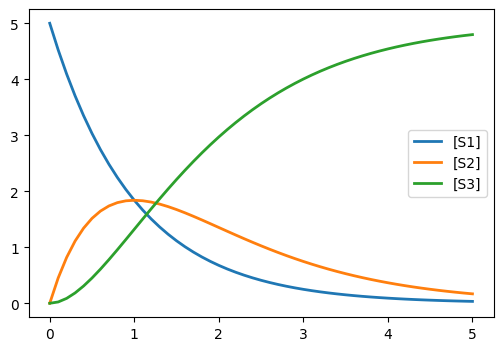

In [4]:
reference_model = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 5
S2 = 0
k1 = 1
k2 = 1
"""
rr = te.loada(reference_model)
rr.simulate()
if IS_PLOT:
    rr.plot()

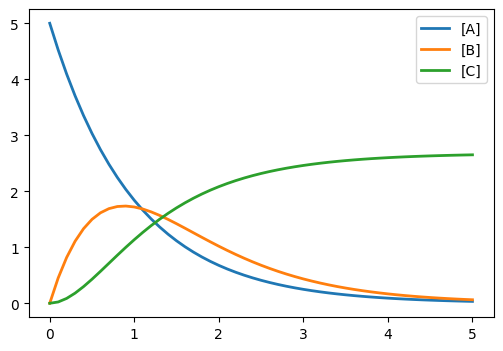

In [5]:
target_model = """
A -> B; k1*A
B -> C; k2*B
B + C -> ; k3*B*C

A = 5
B = 0
k1 = 1
k2 = 1
k3 = 0.2
"""
rr = te.loada(target_model)
rr.simulate()
if IS_PLOT:
    rr.plot()

In [6]:
result = findReferenceInTarget(reference_model, target_model, is_subnet=True, is_report=IS_PLOT)

 mapping pairs: 100%|██████████████████| 1041/1041 [00:00<00:00, 4469058.82it/s]


In [7]:
result

StructurallyIdenticalResult(assignment_pairs=[species: [0 1 2], reaction: [0 1]]; is_truncated=False;

In [8]:
result.mapping_pairs

[species: [0 1 2], reaction: [0 1]]

In [9]:
result.makeInducedNetwork()

2492863: 3 species, 2 reactions
  _J0: A -> B
  _J1: B -> C

# One-Shot, More Elaborate Example

Here we do subnet discovery of an oscillating network in a model in BioModels.

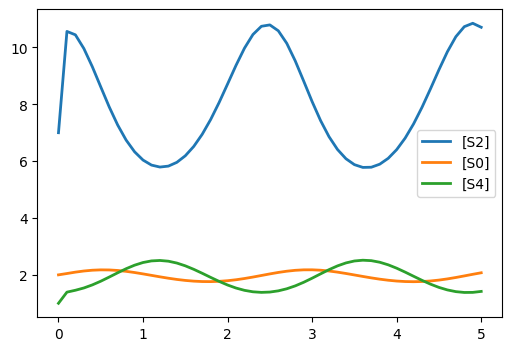

In [10]:
# This is an oscillating network
reference_model = """
J1: $S3 -> S2;  S3*19.3591127845924;
J2: S0 -> S4 + S0;  S0*10.3068257839885;
J3: S4 + S2 -> S4;  S4*S2*13.8915863630362;
J4: S2 -> S0 + S2;  S2*0.113616698747501;
J5: S4 + S0 -> S4;  S4*S0*0.240788980014622;
J6: S2 -> S2 + S2;  S2*1.36258363821544;
J7: S2 + S4 -> S2;  S2*S4*1.37438814584166;

S0 = 2; S1 = 5; S2 = 7; S3 = 10; S4 = 1;
"""
rr = te.loada(reference_model)
rr.simulate()
if IS_PLOT:
    rr.plot()

In [11]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1701090001/3/BIOMD0000000695_url.xml"

In [12]:
# This takes about 10 minutes to run on Colab. If you are in a local environment,
#   set num_process=-1 so that parallel processing can be used. Parallel processing causes problems in Colab.
result = findReferenceInTarget(
        reference_model,                                        # Reference model as an Antimony string
        ModelSpecification(URL, specification_type="sbmlurl"),  # Target as a URL in BioModels
        max_num_mapping_pair=1e14,                              # Maximum number of mapping pairs considered
        is_subnet=True,                                         # Checking for subnet, not equality
        num_process=1,                                          # No process parallelism
        identity=cn.ID_WEAK,                                    # Look for weak identity
        is_report=IS_PLOT)                                      # Provide status information

 mapping pairs: 100%|████████| 483646637/483646637 [03:28<00:00, 2324119.48it/s]


We can see all of the mappings of target species to reference speces and target reactions to reference reactions.

In [13]:
len(result.mapping_pairs)

330

We can also see the induced network, a subnet of the target network that is (weakly) structurally identical with the reference network. Note that since we use weak identity, some of the bi-uni reactions in the reference network are assigned to uni-null reactions in the target network.

In [14]:
result.makeInducedNetwork(1)

1511221: 4 species, 7 reactions
  R_31: xFinal_2 -> xFinal_1
  R_14: xFinal_7 -> 2.0 xFinal_7
  R_33: xFinal_1 + xFinal_2 -> xFinal_2
  R_24: xFinal_2 -> xFinal_3 + xFinal_2
  R_25: xFinal_3 -> 
  R_32: xFinal_1 + xFinal_2 -> 2.0 xFinal_1 + xFinal_2
  R_16: xFinal_7 -> 

Note that R_16 is assigned to J3. Note that J3 is a bi-uni reaction, but R_16 is uni-null. This reaction-mapping makes sense for weak identity since S4 is a reactant and a product in J3.

We illustrate below the use of the keyword parameter ``max_num_mapping_pair``, which controls the maximum number of mapping pairs that will be evaluated. If it is set too small, then ``result.is_truncated`` will be True, indicatilng that mapping pairs exist but were not evaluated.

In [15]:
# Runs fast because is_truncated is True
rr = te.loadSBMLModel(URL)
result = findReferenceInTarget(reference_model, ModelSpecification(rr, specification_type="roadrunner"), 
        max_num_mapping_pair=1, is_subnet=True, num_process=1,
        identity=cn.ID_WEAK, is_report=IS_PLOT)

In [16]:
result.is_truncated

True

# Comparing Directories of Models

``pySubnetSB`` can search for subsets in directories of models. Given a a directory of reference models
and a directory of target models, each target model is searched for each reference model. A "directory" can be a folder in a file system or it can be a file containing a serialization of such a directory (one serialized network per line, as described in the next section). The file can be in the local file system or a URL to a file on the Internet. In the example below, the serializations of references and targets are URLs in the ``github`` repository for ``pySubnetSB``.

A serialization of biomodels is [here](http://raw.githubusercontent.com/ModelEngineering/pySubnetSB/main/data/biomodels_serialized.txt).

In [17]:
reference_url = "http://raw.githubusercontent.com/ModelEngineering/pySubnetSB/main/examples/reference_serialized.txt"
target_url = "http://raw.githubusercontent.com/ModelEngineering/pySubnetSB/main/examples/target_serialized.txt"
result_df = findReferencesInTargets(reference_url, target_url, is_report=IS_PLOT)

Processing reference model: BIOMD0000000031


 mapping pairs: 100%|█████████████████████| 260/260 [00:00<00:00, 180161.74it/s]


Found matching model: BIOMD0000000031 and BIOMD0000000170
Processing reference model: BIOMD0000000031


 mapping pairs: 100%|███████████████████| 1040/1040 [00:00<00:00, 532220.13it/s]


Found matching model: BIOMD0000000031 and BIOMD0000000228
Processing reference model: BIOMD0000000031


 mapping pairs: 100%|████████████████████| 260/260 [00:00<00:00, 1175128.28it/s]


Found matching model: BIOMD0000000031 and BIOMD0000000354
Processing reference model: BIOMD0000000031
Processing reference model: BIOMD0000000027


 mapping pairs: 100%|████████████████████| 312/312 [00:00<00:00, 1695107.32it/s]


Found matching model: BIOMD0000000027 and BIOMD0000000170
Processing reference model: BIOMD0000000027


 mapping pairs: 100%|█████████████████████| 312/312 [00:00<00:00, 757304.89it/s]


Found matching model: BIOMD0000000027 and BIOMD0000000228
Processing reference model: BIOMD0000000027


 mapping pairs: 100%|████████████████████| 312/312 [00:00<00:00, 1913191.30it/s]


Found matching model: BIOMD0000000027 and BIOMD0000000354
Processing reference model: BIOMD0000000027
Processing reference model: BIOMD0000000121
Processing reference model: BIOMD0000000121
Processing reference model: BIOMD0000000121
Processing reference model: BIOMD0000000121


 mapping pairs: 100%|█████████████████████| 416/416 [00:00<00:00, 768986.54it/s]

Found matching model: BIOMD0000000121 and BIOMD0000000960


The output of this method is a dataframe that summarizes subnet discovery.
* reference_name: name of the model in the reference directory
* target_name: name of the model in the target directory
* reference_network: Antimony representation of the complete reference model
* induced_network: Antimony model of the induced network found in the target
* name_dct: dictionary that specifies the species and reaction mappings for the first mapping pair
* num_mapping_pair: number of mapping pairs
* is_truncated: True if the search was truncated because it exceeded the parameter max_num_mapping_pair

In [18]:
result_df

,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated,num_mapping_pair
0,BIOMD0000000031,BIOMD0000000170,"BIOMD0000000031: 6 species, 4 reactions\n v1:...","571341: 6 species, 4 reactions\n BMAL1_nuclea...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",48,False,48
1,BIOMD0000000031,BIOMD0000000228,"BIOMD0000000031: 6 species, 4 reactions\n v1:...","5498389: 6 species, 4 reactions\n pRB_phospho...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",240,False,240
2,BIOMD0000000031,BIOMD0000000354,"BIOMD0000000031: 6 species, 4 reactions\n v1:...","1066351: 6 species, 4 reactions\n JChannel: C...","{""species_names"": {""M"": ""CaS"", ""Mp"": ""CaI"", ""M...",12,False,12
3,BIOMD0000000031,BIOMD0000000960,,,,,False,
4,BIOMD0000000027,BIOMD0000000170,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","2801125: 5 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",24,False,24
5,BIOMD0000000027,BIOMD0000000228,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","297960: 5 species, 4 reactions\n pRB_phosphor...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",60,False,60
6,BIOMD0000000027,BIOMD0000000354,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","6560581: 5 species, 4 reactions\n JChannel: C...","{""species_names"": {""M"": ""CaS"", ""Mp"": ""CaI"", ""M...",12,False,12
7,BIOMD0000000027,BIOMD0000000960,,,,,False,
8,BIOMD0000000121,BIOMD0000000170,,,,,False,
9,BIOMD0000000121,BIOMD0000000228,,,,,False,


# Serialize models

You can serialize models to facilitate using ``pySubnetSB``.
This is illustrated in the following cells.

In [19]:
# Clone pySubnetSB to get a directory of files to serialize
!git clone https://github.com/ModelEngineering/pySubnetSB.git

Cloning into 'pySubnetSB'...
remote: Enumerating objects: 3663, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 3663 (delta 10), reused 21 (delta 8), pack-reused 3636 (from 3)
Receiving objects: 100% (3663/3663), 115.42 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (2604/2604), done.


In [20]:
# Establish the paths for serialization. The results will be in the file serialization.txt
cur_dir = os.path.abspath(".")
directory = os.path.join(cur_dir, "pySubnetSB/src/pySubnetSB_tests/xml_files")
serialization_path = os.path.join(cur_dir, "serialization.txt")
makeSerializationFile(directory, serialization_path, is_report=IS_PLOT)

..Done!


In [21]:
# Display the first line of the serialization file. Each network is a separate line. Lines can be appended or deleted.
with open(serialization_path, "r") as fd:
    lines = fd.readlines()
if IS_PLOT:
    print(lines[0])

{"s_id": "Network", "s_network_name": "BIOMD0000000033", "s_reactant_lst": [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 

In [22]:
# Clean up the cloned repository
!rm -rf pySubnetSB